# Incremental Factorization Machines for Item Recommendation in Data Streams

In [1]:
import matplotlib as mpl 
mpl.use("pgf") 
pgf_with_rc_fonts = {
    "font.serif": [],
}

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['axes.labelsize'] = 'large'
mpl.rcParams['axes.facecolor'] = 'w'

In [2]:
%load_ext autoreload
%autoreload 2
from experiment import Runner

In [3]:
exp = Runner()

### Plot-related preparation

In [4]:
# http://public.tableau.com/profile/chris.gerrard#!/vizhome/TableauColors/ColorPaletteswithRGBValues
colors = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
          (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
          (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),   
          (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
          (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

# [0, 255] -> [0.0, 1.0]
for i in range(len(colors)): 
    r, g, b = colors[i]    
    colors[i] = (r / 255., g / 255., b / 255.) 

In [5]:
def plot_setting(fig, ax, head=0):
    ax.set_xlabel('sample index', fontsize=11)
    ax.set_ylabel('average of recall@10', fontsize=11)
    ax.yaxis.grid(True)
    ax.set_yticks([0.00, 0.025, 0.05, 0.075, 0.10, 0.125, 0.15])
    ax.set_ylim([0.0, 0.15])
    
    # 20% pre-train | 80% evaluate
    ax.axvline(x=head, linewidth=1, linestyle='--', color=colors[14])
    
    # head-of-evaluate | first 5000 samples (1st window)
    ax.axvline(x=head+5000-1, linewidth=1, linestyle='--', color=colors[14])
    
    fig.set_size_inches((5.5,3))
    fig.patch.set_alpha(0.0)

In [6]:
def show_result(path):
    with open(path) as f:
        lines = map(lambda l: float(l.rstrip()), f.readlines())
        time = lines[0]
        avgs = lines[1:]
        
    fig, ax = plt.subplots()
    ax.plot(np.arange(len(avgs)), avgs)
    plot_setting(fig, ax)
    
    return avgs, time

## Evaluation methodology

Following paper describes how we can evaluate recommender systems in streaming environments.

J. Vinagre, et al., "**Evaluation of Recommender Systems in Streaming Environments**," Proc. of REDD 2014, Oct. 2014.

The key idea is a *test-then-learn* procedure. To give an example, for the Movielens-1M dataset, the authors set the following evaluation procedure with positive-only setting (i.e. use only positive "5" ratings):

1. Initialize a model with the first 20% events.
2. Observe an evant *(user, item, rating)* one-by-one.
    - If *user* is already known:
        - generate recommendation list and check if *item* is in the list (i.e. compute **recall@10**).
        - compute Simple Moving Average (SMA) of **recall@10** for the most recent $n=5000$ events.
3. Update the model based on the observed event, and proceed 2.

### Baseline

train 20% and use the model for all new observations

0.000378765802439

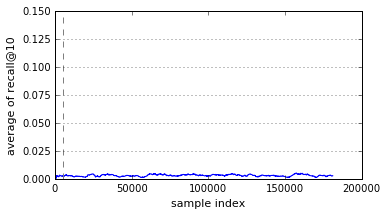

In [7]:
base_avgs, base_time = show_result('results/baseline.txt')
base_time

### Incremental Matrix Factorization (iMF)

- Run a test-then-learn procedure
- Simple Moving Average (SMA) with window size $n=5000$

0.000390318810481

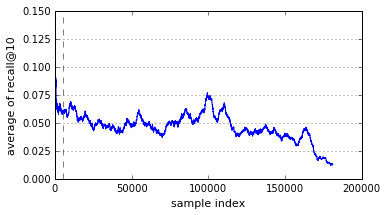

In [8]:
iMF_avgs, iMF_time = show_result('results/iMF.txt')
iMF_time

### Incremental Biased Matrix Factorization (Biased-iMF)

As one specific case of Factorization Machines.

Regularization parameters for the bias terms are updated adaptively.

0.000434940965932

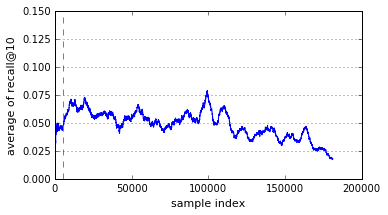

In [9]:
biased_iMF_avgs, biased_iMF_time = show_result('results/biased-iMF.txt')
biased_iMF_time

### Incremental Factorization Machines (no context)

Naive implementation of FMs in incremental fashion with mimicking Biased-iMF

CPU times: user 210 ms, sys: 16.5 ms, total: 227 ms
Wall time: 240 ms


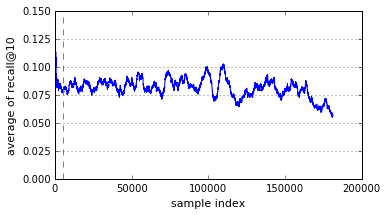

In [10]:
%%time
iFMs_avgs, iFMs_time = show_result('results/iFMs_no_context_tmp.txt')
iFMs_time

### Incremental Factorization Machines (with context; time-awared)

0.0212491115119

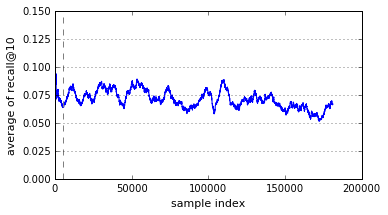

In [11]:
iFMs_ctx_avgs, iFMs_ctx_time = show_result('results/iFMs_contexts_tmp.txt')
iFMs_ctx_time

### Compare the result

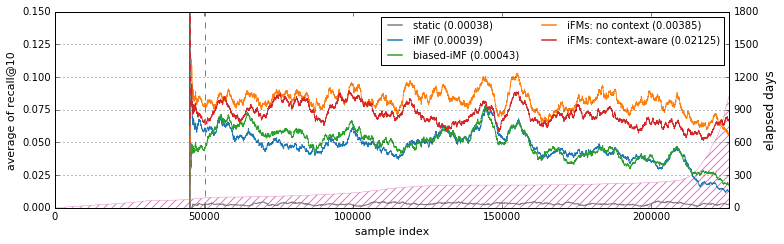

In [51]:
fig, ax = plt.subplots()

# axis #2: the distribution of a 'time' feature
ax2 = ax.twinx()
ax2.plot(exp.dts, c=colors[12], lw=.4)
ax2.set_xlim((0, exp.n_sample-1))
ax2.set_yticks([0, 300, 600, 900, 1200, 1500, 1800])
ax2.set_ylim([0, 1800])
ax2.fill_between(np.arange(exp.n_sample), np.array(exp.dts), facecolor='none', edgecolor=colors[12], lw=0, hatch='///')
ax2.set_ylabel('elapsed days')

# axis #1: simple moving average of recall
x = np.arange(len(base_avgs))+exp.n_train
ax.plot(x, base_avgs, c=colors[14], label='static (%.5f)' % base_time)
ax.plot(x, iMF_avgs, c=colors[0], lw=.8, label='iMF (%.5f)' % iMF_time)
ax.plot(x, biased_iMF_avgs, c=colors[4], lw=.8, label='biased-iMF (%.5f)' % biased_iMF_time)
ax.plot(x, iFMs_avgs, c=colors[2], lw=.8, label='iFMs: no context (%.5f)' % iFMs_time)
ax.plot(x, iFMs_ctx_avgs, c=colors[6], lw=.8, label='iFMs: context-aware (%.5f)' % iFMs_ctx_time)
ax.set_xlim((0, exp.n_sample-1))
ax.set_zorder(ax2.get_zorder()+1)
ax.patch.set_visible(False)

plot_setting(fig, ax, exp.n_train-1)
fig.set_size_inches((11,3.5))

leg = ax.legend(fontsize=10, loc='upper right', ncol=2)
for legobj in leg.legendHandles:
    legobj.set_linewidth(1.5)
    
plt.tight_layout()
fig.savefig('../../paper/images/jsai-2016/jsai-2016-ml-1m-recall.eps')

|model||l2_reg_w0|l2_leg_w|l2_leg_V|learn_rate|k|
|:---:|:---:|---:|---:|---:|---:|---:|
|iMF||0.01|||0.03|4|
|biased-iMF||0.01|0.01|0.01|0.03|4|
|iFMs: no context|init|0.01|0.01|30.0|0.003|4|
||after last sample|0.808053101956|0.239016128563||||
|iFMs: context-aware|init|0.010|0.010|30.0|0.003|4|
||after last sample|0.0516456977036|0.0463758494545||||

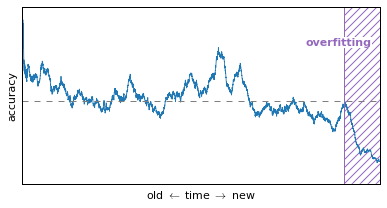

In [49]:
fig, ax = plt.subplots()

x = np.arange(len(iMF_avgs))
ax.plot(x, iMF_avgs, lw=.8, label='iMF', c=colors[0])

ax.set_xlabel(r'old $\leftarrow$ time $\rightarrow$ new', fontsize=11)
ax.set_ylabel('accuracy', fontsize=11)
ax.yaxis.grid(True)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim([0, len(iMF_avgs)])
ax.set_ylim([0.0, 0.1])

fig.set_size_inches((5.5,3))
fig.patch.set_alpha(0.0)

ax.axhline(y=np.mean(iMF_avgs), linewidth=1, linestyle='--', color=colors[14])

head = 163000
tail = len(iMF_avgs)
ax.axvline(x=head, linewidth=1, linestyle='-', color=colors[8])
ax.fill_between(np.arange(head, tail), np.ones(tail-head), facecolor='none', edgecolor=colors[8], hatch='///', lw=0)

ax.text(160000, 0.08, 'overfitting', size=11, ha='center', va='center', fontweight='bold', color=colors[8],
       bbox={'facecolor':'white', 'alpha':1, 'pad':.3, 'lw': 0})

plt.tight_layout()
fig.savefig('../../paper/images/jsai-2016/jsai-2016-fail-example.eps')

### Check the distribution of a 'time' feature

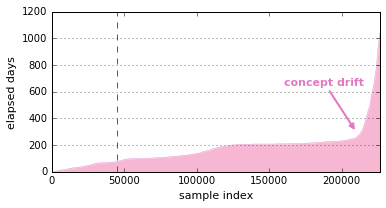

In [50]:
fig, ax = plt.subplots()

#ax2 = ax.twinx()
#x = np.arange(len(iMF_avgs)-256) + exp.n_train + 256
#ax2.plot(x, iMF_avgs[256:], lw=.4, label='iMF', c=colors[12])
#ax2.set_yticks([])
#ax2.set_ylim([0.0, 0.1])

ax.plot(exp.dts, c=colors[12], lw=.4)
ax.set_xlim((0, exp.n_sample-1))
ax.fill_between(np.arange(exp.n_sample), np.array(exp.dts), facecolor=colors[13], lw=0)

# 20% pre-train | 80% evaluate
ax.axvline(x=exp.n_train, linewidth=1, linestyle='--', color=colors[6])

ax.yaxis.grid(True)
fig.set_size_inches((5.5,3))

ax.set_xlabel('sample index', fontsize=11)
ax.set_ylabel('elapsed days', fontsize=11)

ax.annotate('concept drift', xy=(210000, 300), xytext=(160000, 650), size=11, fontweight='bold', color=colors[12],
            arrowprops=dict(color=colors[12], lw=2, arrowstyle='-|>'))

plt.tight_layout()
fig.savefig('../../paper/images/jsai-2016/jsai-2016-ml-1m-elapsed-days.eps')